<a href="https://colab.research.google.com/github/Mateusz0W/Inflation-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from process_data import combine_model_args,add_target_inflations,normalize_and_split_data_chronologically,prepare_inference_data, prepare_training_data
from load_data import load_avarage_salary,load_building_price,load_inflation,load_unemployed,load_notional_amount
from evaluate_model import plot_predicted_inflation, calculate_metrics, print_table
from sklearn.neural_network import MLPRegressor

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	
TRAIN: R2=0.6802337010177179, MSE=4.429631616865678, RMSE=2.104669004111021, MAPE=0.010135709669285982
TEST: R2=0.8927843252073597, MSE=1.6514740122482001, RMSE=1.2850968882727092, MAPE=0.007661286038890544


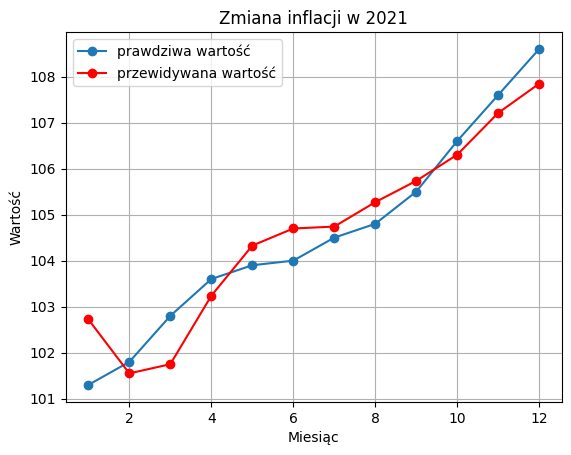

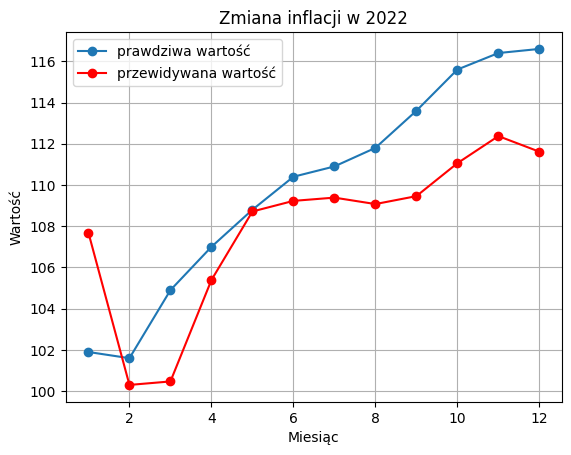

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflM	
TRAIN: R2=0.5867113418456347, MSE=5.691852726888921, RMSE=2.3857604085257433, MAPE=0.015382536236885942
TEST: R2=0.7506422647614257, MSE=4.047308776808284, RMSE=2.0117924288574813, MAPE=0.01523204511299413


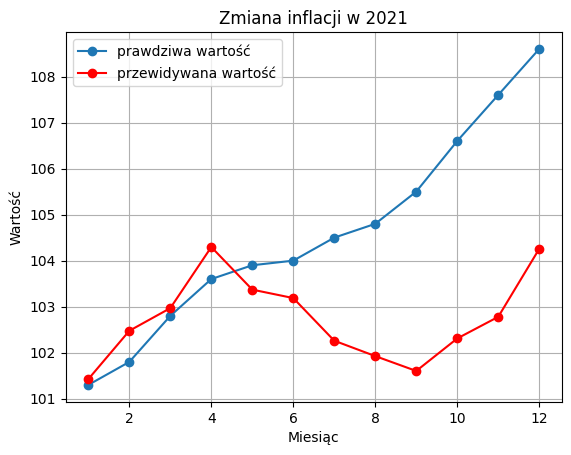

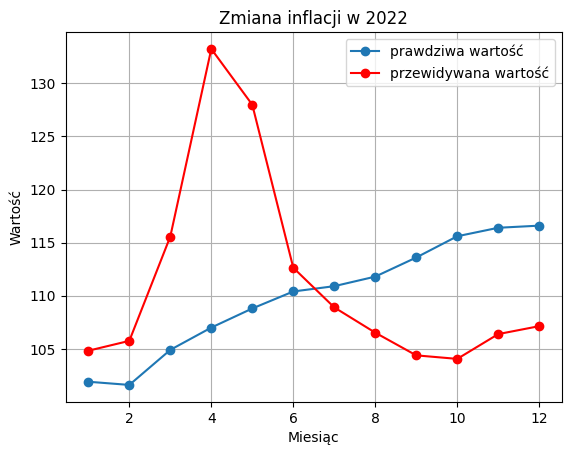

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
bezrob	
TRAIN: R2=0.18514783721113492, MSE=11.445539706331626, RMSE=3.383125730198573, MAPE=0.022088663949368537
TEST: R2=0.3499869755074162, MSE=8.909561380513546, RMSE=2.9848888388872283, MAPE=0.018256099992336725


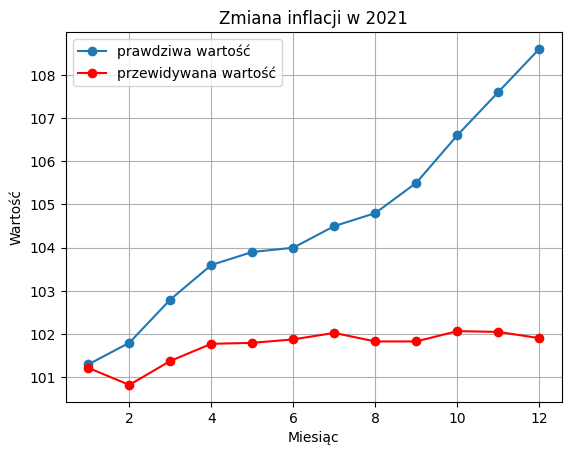

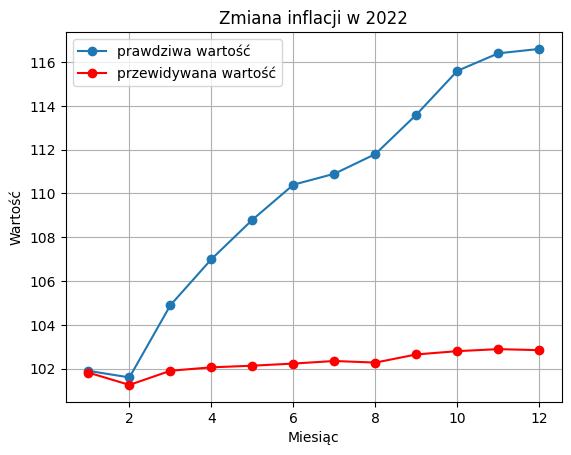

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
mieszk	
TRAIN: R2=0.13694547858219308, MSE=2.738425263599775, RMSE=1.6548188008358422, MAPE=0.01221427339358469
TEST: R2=0.30335867370855696, MSE=1.8973611700261526, RMSE=1.3774473383858101, MAPE=0.010536898719292443


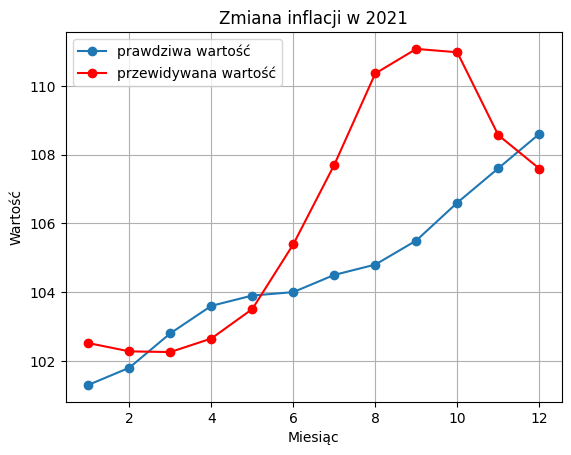

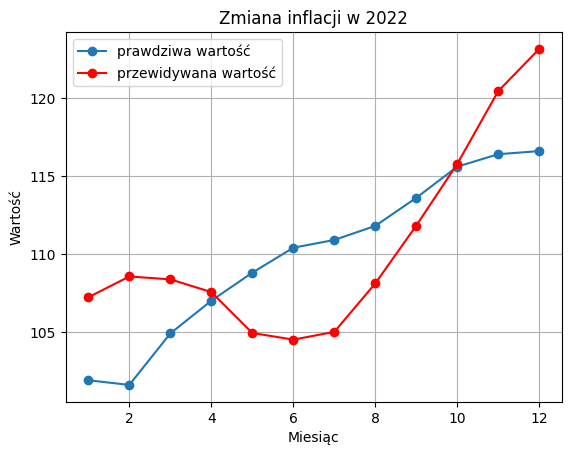

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
wynag	
TRAIN: R2=0.3903481424351414, MSE=8.959802758525042, RMSE=2.9932929623618603, MAPE=0.021271110363161042
TEST: R2=-11.066474231281932, MSE=107.3064766547026, RMSE=10.358883948317144, MAPE=0.03789167374232087


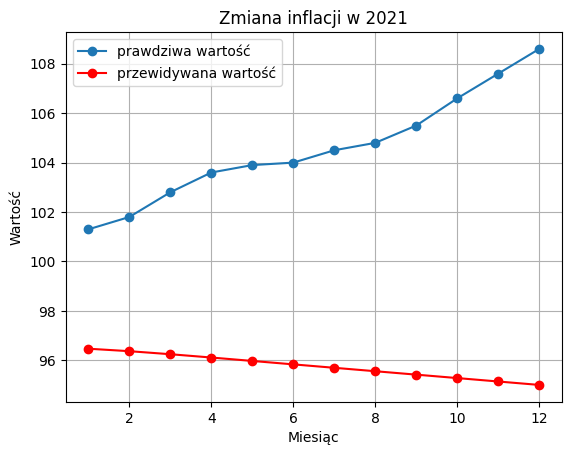

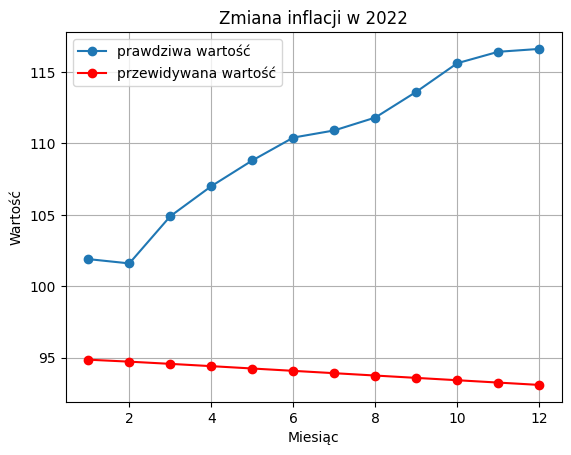

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
baz	
TRAIN: R2=0.367701546806639, MSE=2.0847607996603754, RMSE=1.4438700771400366, MAPE=0.010181401082964503
TEST: R2=-0.8258254834400458, MSE=3.100067820398486, RMSE=1.760700945759525, MAPE=0.012996079790540752


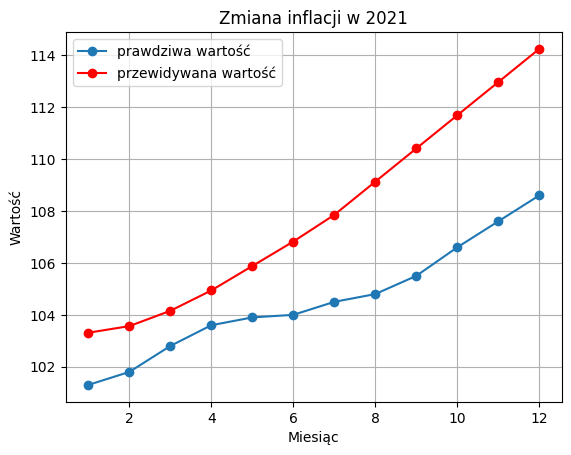

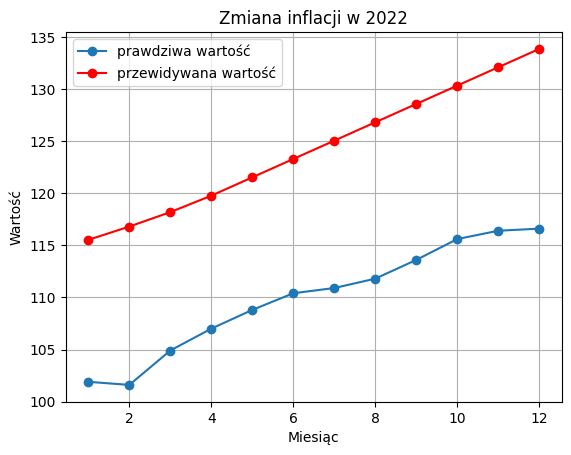

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	
TRAIN: R2=0.7238515516745817, MSE=3.129709574884527, RMSE=1.7690985204008642, MAPE=0.010334355908975074
TEST: R2=0.78829225576782, MSE=6.386809597355307, RMSE=2.5272138012750935, MAPE=0.01590236983436169


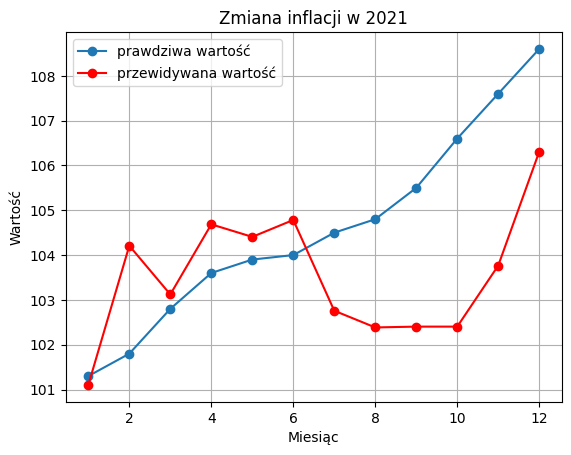

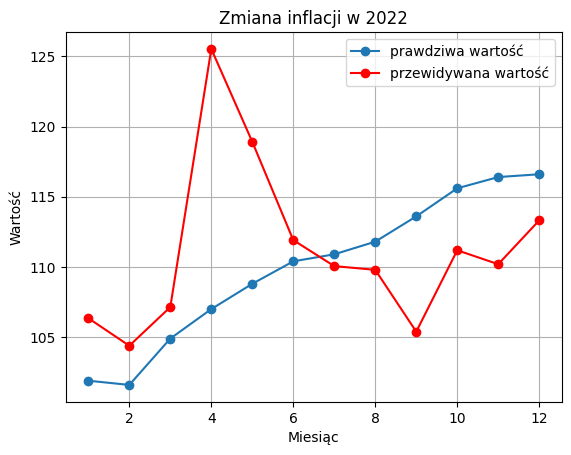

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	mieszk	
TRAIN: R2=0.5878982921079905, MSE=1.3256386130052806, RMSE=1.1513638056692943, MAPE=0.007432251367022176
TEST: R2=0.519458548822564, MSE=0.953442160167174, RMSE=0.9764436287708441, MAPE=0.005908456493427842


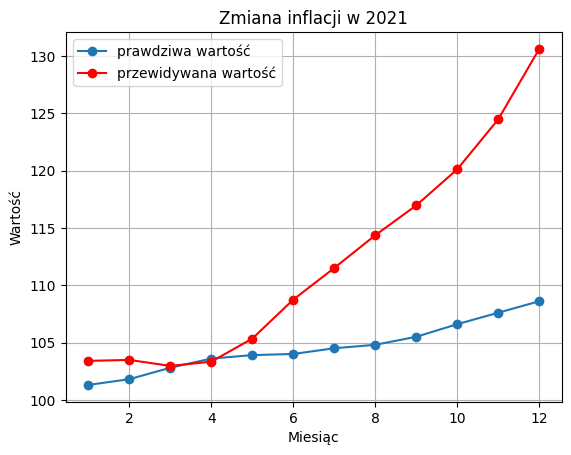

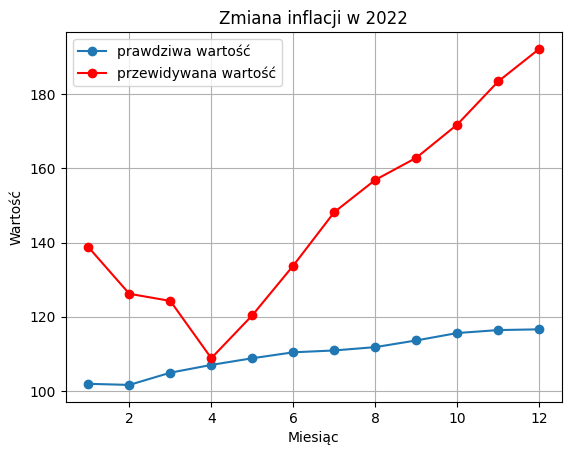

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	baz	
TRAIN: R2=0.5241198557801774, MSE=1.398789173607011, RMSE=1.1827041784009267, MAPE=0.008350708415513348
TEST: R2=0.5611934608356498, MSE=2.100893375044882, RMSE=1.4494458855179388, MAPE=0.011199891718164812


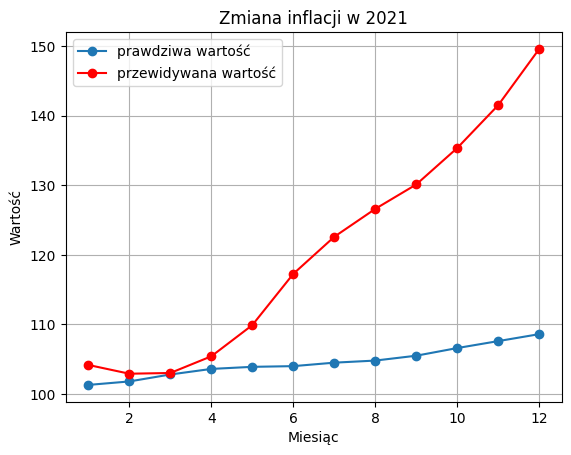

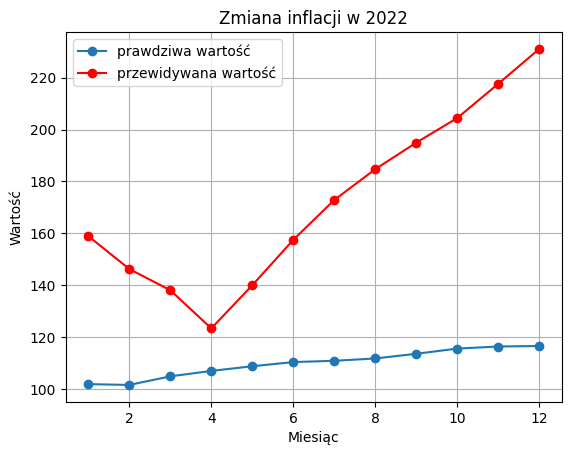

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	bezrob	mieszk	wynag	baz	
TRAIN: R2=0.5555830943047153, MSE=1.4077906218593936, RMSE=1.1865035279591012, MAPE=0.008836135869580196
TEST: R2=-2.0525080602317844, MSE=9.451015027009667, RMSE=3.074250319510379, MAPE=0.019586264383790287


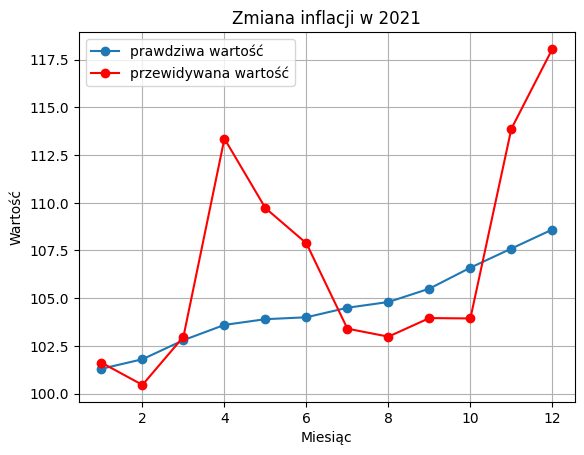

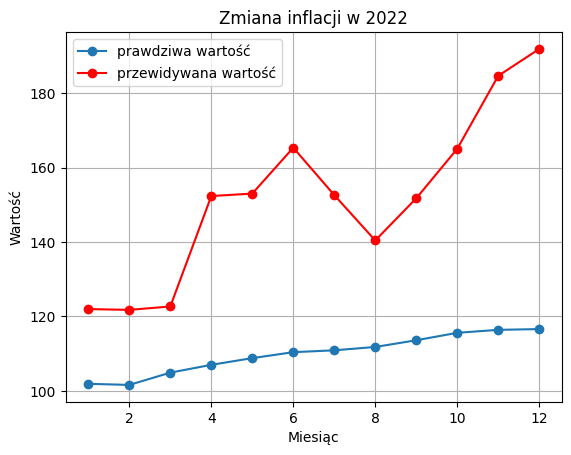

In [47]:
names = ["inflR", "inflM", "bezrob", "mieszk", "wynag", "baz"]

model_args_indices_tab = [[0], [1], [2], [3], [4], [5], [0, 1], [0, 3], [0, 5], [0,1,2,3,4,5]]
models = [MLPRegressor(solver='adam',hidden_layer_sizes=(15, 15),
                       max_iter = 3_000, tol = 1e-3, activation = 'relu')] * len(model_args_indices_tab)
inflation_steps = [3] * len(model_args_indices_tab)
steps = [3] * len(model_args_indices_tab)
start_years = [1995] * len(model_args_indices_tab)
end_years = [2020] * len(model_args_indices_tab)
inference_years = [2021] * len(model_args_indices_tab)

R2s = []
MSEs = []
RMSEs = []
MAPEs = []

loop_parameters = zip(inflation_steps, steps, model_args_indices_tab, start_years,
                      end_years, inference_years, models, strict=True)
for inflation_step, step, indices, start_year, end_year, inference_year, model in loop_parameters:
    inflation_dict = load_inflation(step = inflation_step)
    target_inflation_dict = {key: inflation_dict[key][1] for key in inflation_dict}
    inflation_to_last_year_dict = {key: inflation_dict[key][0][:inflation_step] for key in inflation_dict}
    inflation_to_last_month_dict = {key: inflation_dict[key][0][inflation_step:] for key in inflation_dict}
    unemployed_dict = load_unemployed(step = step)
    building_price_dict = load_building_price(step = step)
    average_salary_dict = load_avarage_salary(step = step)
    notional_amount = load_notional_amount(step=step)
    args_dict_tab = [inflation_to_last_year_dict, inflation_to_last_month_dict,
                    unemployed_dict, building_price_dict, average_salary_dict,
                     notional_amount]
    model_args_tab = []
    print("Wskaźniki:")
    for index in indices:
        model_args_tab.append(args_dict_tab[index])
        print(names[index], end="\t")
    print()
    final_data = prepare_training_data(model_args_tab, target_inflation_dict, start_year, end_year)
    X_train, X_test, y_train, y_test, scaler = normalize_and_split_data_chronologically(final_data, test_size=0.1)
    model.fit(X_train, y_train)
    R2, MSE, RMSE, MAPE = calculate_metrics(X_train,y_train,model)
    print(f"TRAIN: {R2=}, {MSE=}, {RMSE=}, {MAPE=}")
    R2, MSE, RMSE, MAPE = calculate_metrics(X_test,y_test,model)
    print(f"TEST: {R2=}, {MSE=}, {RMSE=}, {MAPE=}")
    R2s.append(R2)
    MSEs.append(MSE)
    RMSEs.append(RMSE)
    MAPEs.append(MAPE)
    inference_data = prepare_training_data(model_args_tab, target_inflation_dict, inference_year, inference_year)
    X, y = prepare_inference_data(inference_data, scaler)
    y_pred = model.predict(X)
    plot_predicted_inflation(y,y_pred,inference_year)
    inference_data = prepare_training_data(model_args_tab, target_inflation_dict, inference_year+1, inference_year+1)
    X, y = prepare_inference_data(inference_data, scaler)
    y_pred = model.predict(X)
    plot_predicted_inflation(y,y_pred,inference_year+1)

In [48]:
columns = ['Parametry eksperymentu', 'R2', 'MSE', "RMSE", "MAPE"]
parameters_str = [
    'Wskaźniki: inflR; zasięg: 3',
    'Wskaźniki: inflM; zasięg: 3',
    'Wskaźniki: bezrob; zasięg: 3',
    'Wskaźniki: mieszk; zasięg: 3',
    'Wskaźniki: wynag; zasięg: 3',
    'Wskaźniki: baz; zasięg: 3',
    'Wskaźniki: inflR, inflM; zasięg: 3',
    'Wskaźniki: inflR, mieszk; zasięg: 3',
    'Wskaźniki: inflR, baz; zasięg: 3',
    'Wskaźniki: inflR, inflM, bezrob, mieszk, wynag, baz; zasięg: 3',
    ]
values = zip(parameters_str, R2s, MSEs, RMSEs, MAPEs, strict=True)
print_table(columns, values)

Parametry eksperymentu	R2	MSE	RMSE	MAPE
Wskaźniki: inflR; zasięg: 3	0.8928	1.6515	1.2851	0.0077	
Wskaźniki: inflM; zasięg: 3	0.7506	4.0473	2.0118	0.0152	
Wskaźniki: bezrob; zasięg: 3	0.3500	8.9096	2.9849	0.0183	
Wskaźniki: mieszk; zasięg: 3	0.3034	1.8974	1.3774	0.0105	
Wskaźniki: wynag; zasięg: 3	-11.0665	107.3065	10.3589	0.0379	
Wskaźniki: baz; zasięg: 3	-0.8258	3.1001	1.7607	0.0130	
Wskaźniki: inflR, inflM; zasięg: 3	0.7883	6.3868	2.5272	0.0159	
Wskaźniki: inflR, mieszk; zasięg: 3	0.5195	0.9534	0.9764	0.0059	
Wskaźniki: inflR, baz; zasięg: 3	0.5612	2.1009	1.4494	0.0112	
Wskaźniki: inflR, inflM, bezrob, mieszk, wynag, baz; zasięg: 3	-2.0525	9.4510	3.0743	0.0196	


/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	
TRAIN: R2=0.7052338600723158, MSE=4.411486713547508, RMSE=2.100353949587428, MAPE=0.008945125378601898
TEST: R2=0.06597906981048118, MSE=2.3661679339765582, RMSE=1.5382353311429815, MAPE=0.007203678553101316


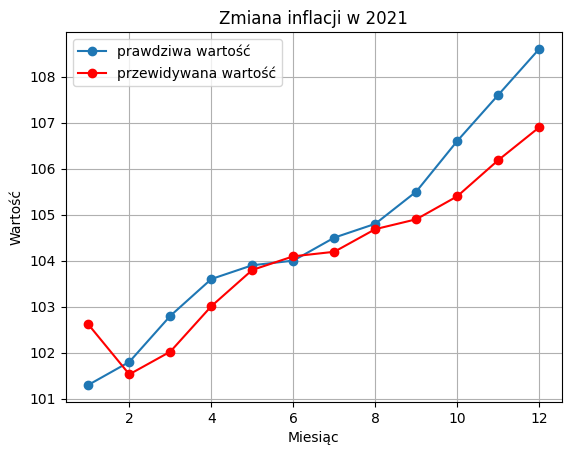

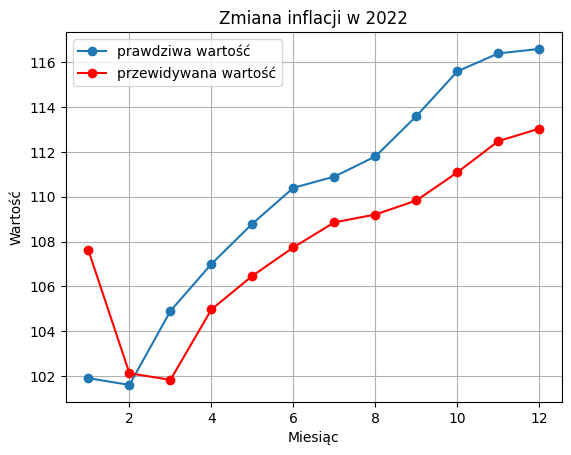

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	
TRAIN: R2=0.6926413953606394, MSE=4.493112522615645, RMSE=2.1196963279242724, MAPE=0.0102016053523989
TEST: R2=0.3317431521635499, MSE=6.130375570891873, RMSE=2.4759595252935522, MAPE=0.011170701214208035


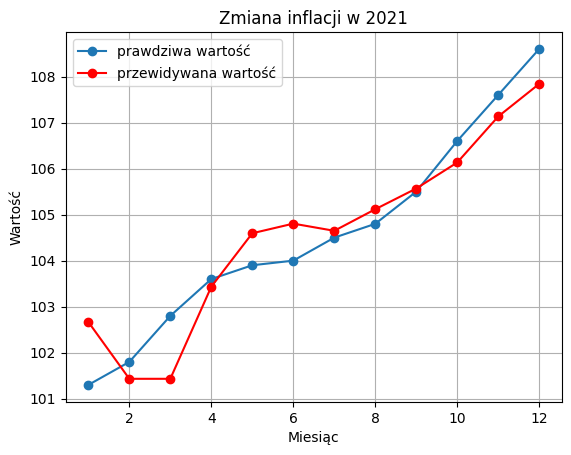

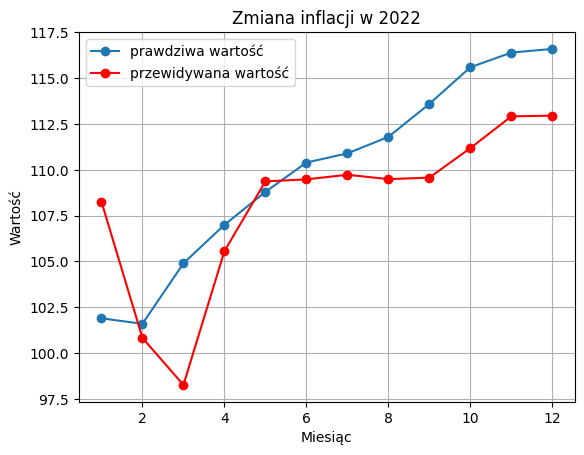

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	
TRAIN: R2=0.8402413675291941, MSE=2.3508445236606175, RMSE=1.5332464001785941, MAPE=0.007147136381869965
TEST: R2=0.18738213403396353, MSE=5.850780987266312, RMSE=2.4188387683486288, MAPE=0.00976874817820109


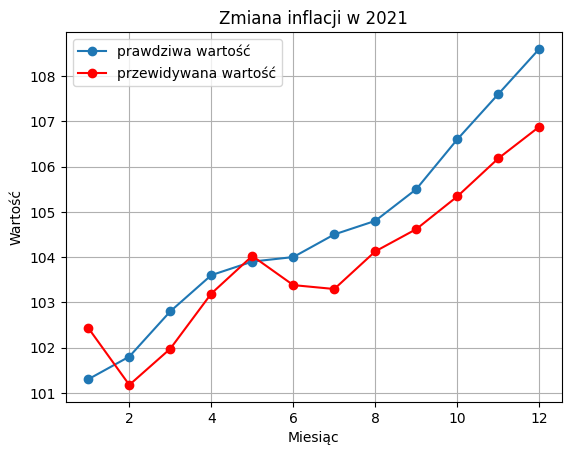

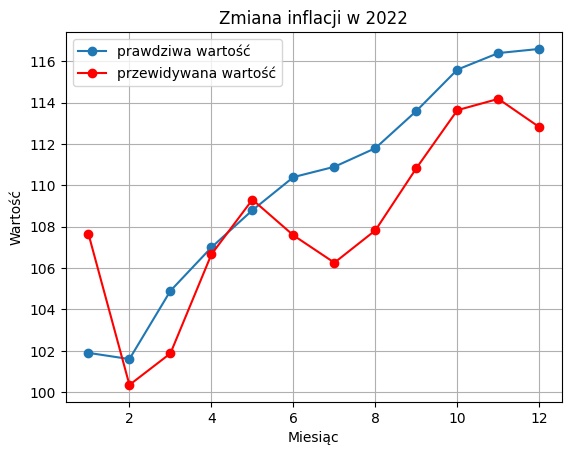

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	
TRAIN: R2=0.9089895240556977, MSE=1.164009581205095, RMSE=1.0788927570454327, MAPE=0.008373737585479461
TEST: R2=0.7795941362921375, MSE=5.404728448294023, RMSE=2.3248071851863377, MAPE=0.012729169961974415


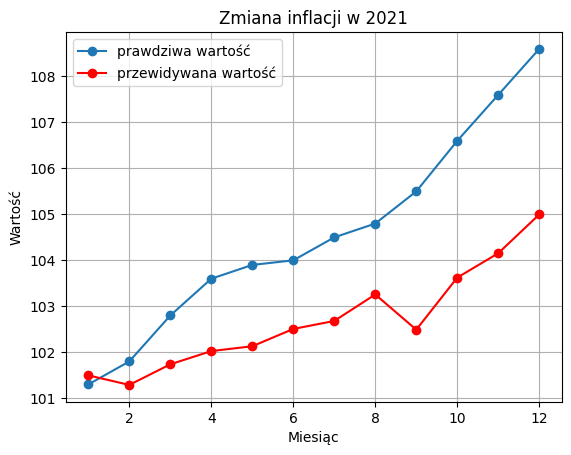

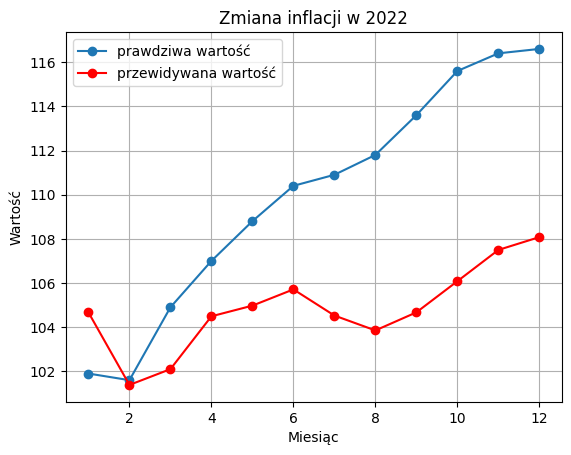

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflM	
TRAIN: R2=0.4032717373257271, MSE=8.038017527186474, RMSE=2.835139772072353, MAPE=0.018159781032274308
TEST: R2=0.4621060104601352, MSE=9.622465294469885, RMSE=3.1020098798150024, MAPE=0.01815808923961647


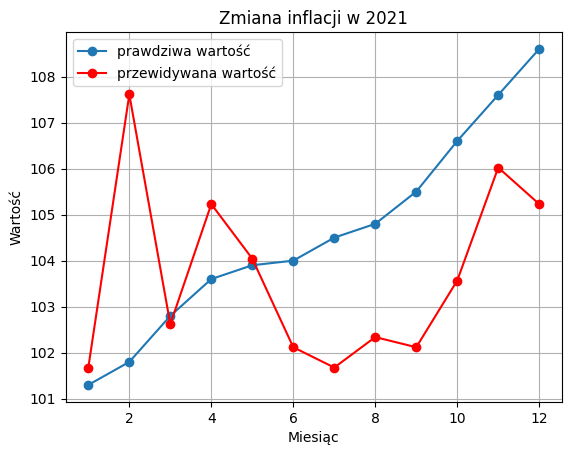

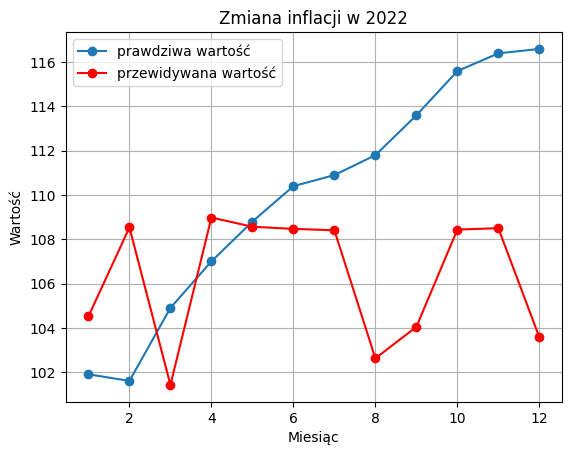

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflM	
TRAIN: R2=0.5944512543314239, MSE=5.9449086967128135, RMSE=2.438218344757666, MAPE=0.015376020970386818
TEST: R2=0.2084241961447385, MSE=7.4722589763355005, RMSE=2.7335433006146985, MAPE=0.016180690656508793


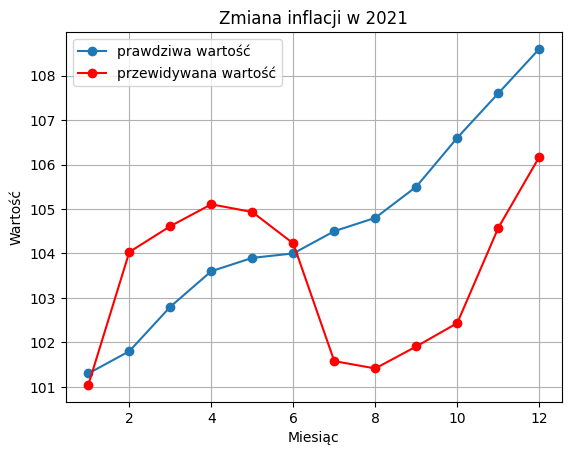

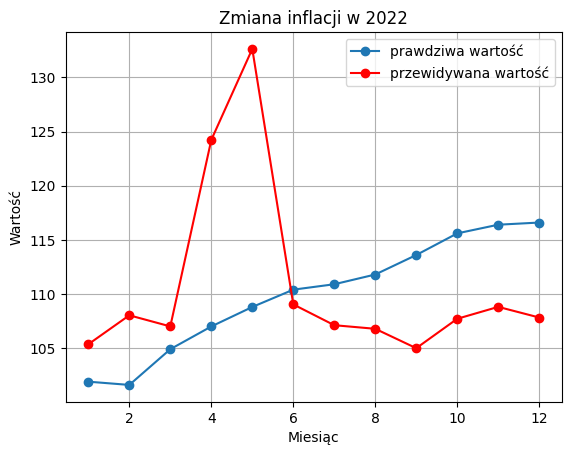

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflM	
TRAIN: R2=0.8434096644893667, MSE=2.152962355566259, RMSE=1.4672976370069772, MAPE=0.00985281232153682
TEST: R2=0.34707813940659415, MSE=10.53637213838476, RMSE=3.2459778400945316, MAPE=0.01787997333448944


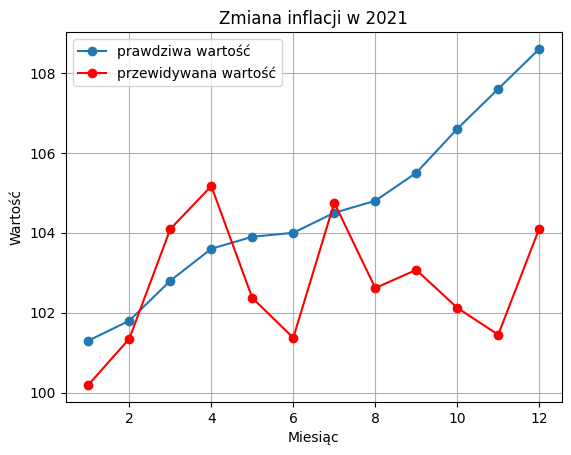

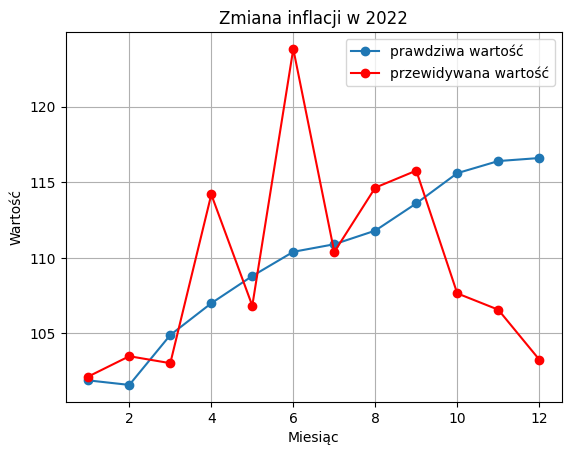

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflM	
TRAIN: R2=0.9333316050893582, MSE=1.001468269073613, RMSE=1.0007338652576983, MAPE=0.006856673496914806
TEST: R2=-2.650217869225967, MSE=18.410644284652324, RMSE=4.290762669345897, MAPE=0.016079437542673856


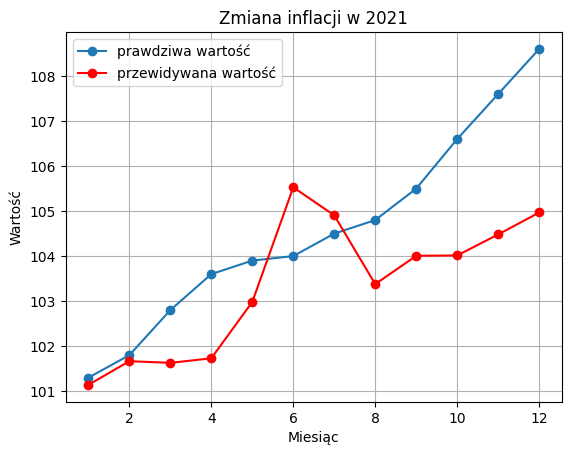

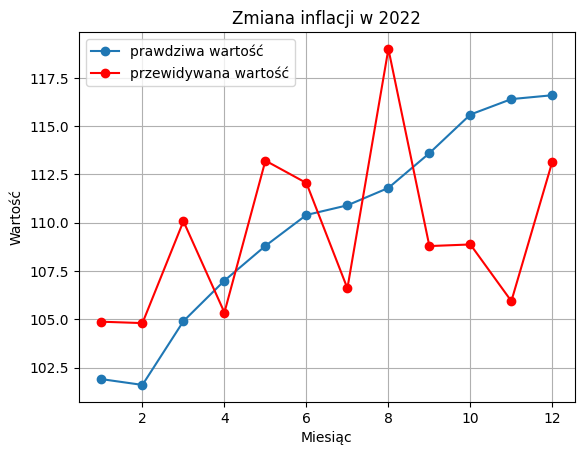

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
baz	
TRAIN: R2=0.2030161625041499, MSE=2.5390129198000038, RMSE=1.5934280403582723, MAPE=0.011367768026761394
TEST: R2=0.4090757520101084, MSE=1.5350935173543494, RMSE=1.2389889092943283, MAPE=0.010357913792924018


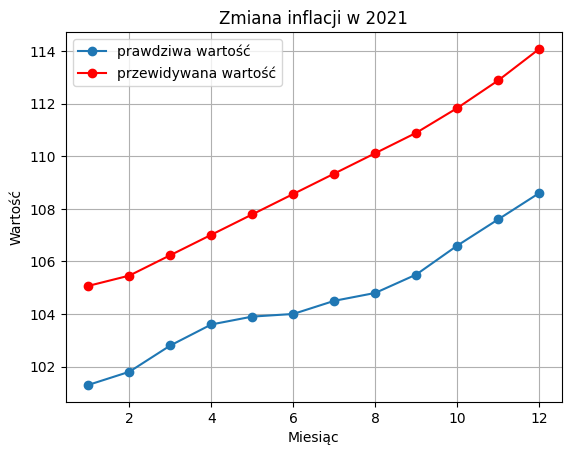

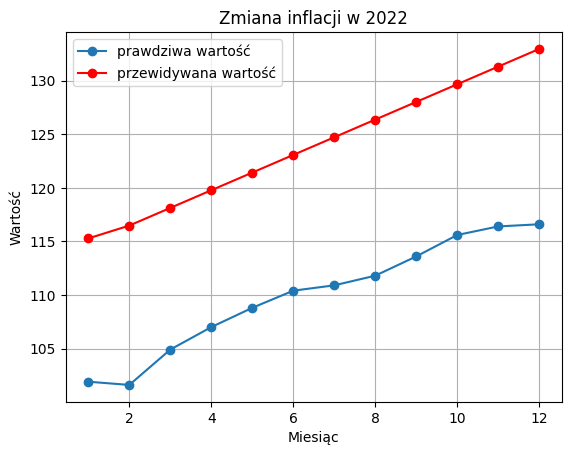

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
baz	
TRAIN: R2=0.5187130185177831, MSE=1.5853880285276039, RMSE=1.2591219275858887, MAPE=0.00936907556893619
TEST: R2=0.40770566722387136, MSE=1.3430940070640442, RMSE=1.1589193272458804, MAPE=0.009166494182599825


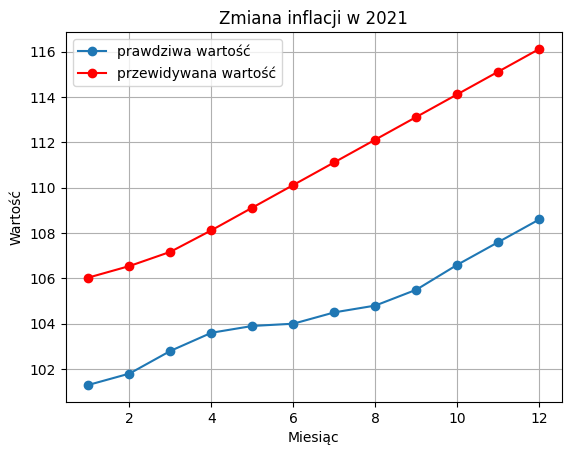

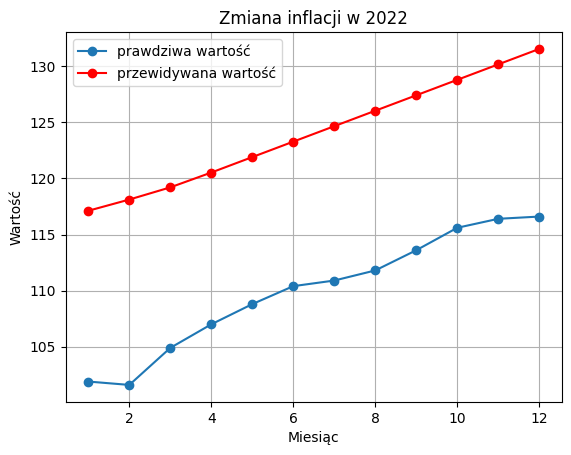

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
baz	
TRAIN: R2=0.40687301248596097, MSE=1.8897214741917878, RMSE=1.3746714058973468, MAPE=0.011087429899611742
TEST: R2=0.44569211517469076, MSE=1.0442633728565414, RMSE=1.021892055383807, MAPE=0.008381316120168326


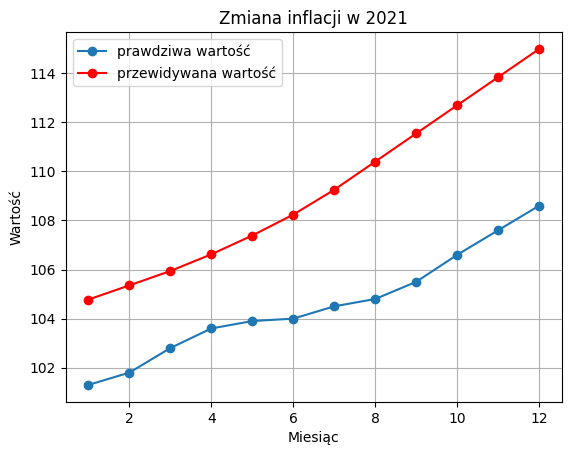

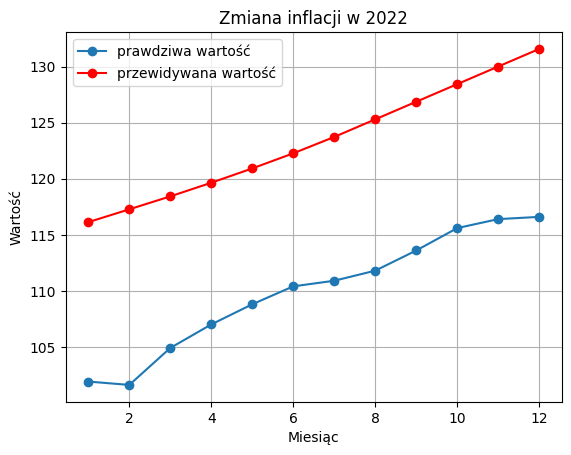

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
baz	
TRAIN: R2=0.38731487832281464, MSE=1.4979094326526003, RMSE=1.2238911032655644, MAPE=0.009086057358638438
TEST: R2=0.5136246218455576, MSE=0.791808337233701, RMSE=0.8898361294270429, MAPE=0.007295299165534556


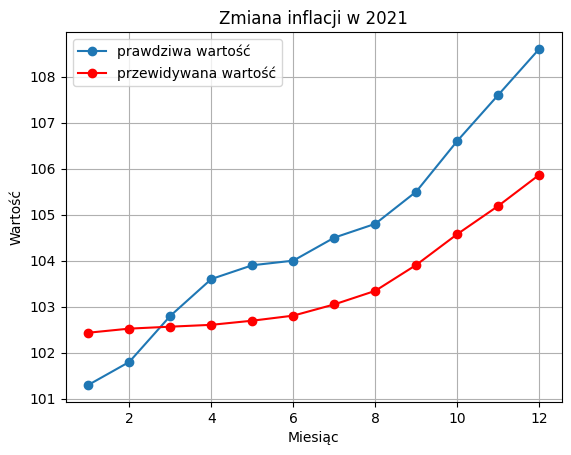

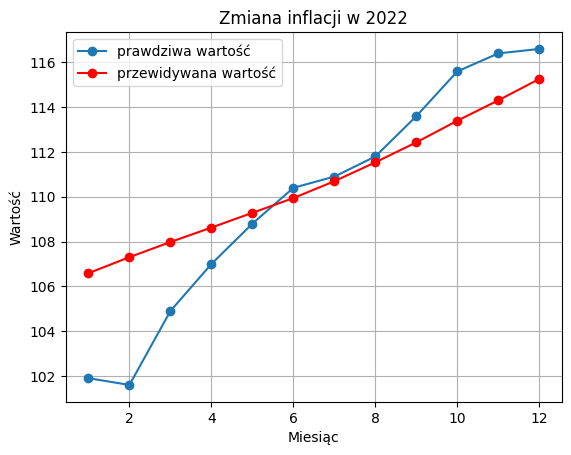

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	baz	
TRAIN: R2=0.5888548607310495, MSE=1.2587894936371284, RMSE=1.1219578840745887, MAPE=0.006969564163502092
TEST: R2=0.9171275382599156, MSE=0.27724419360898844, RMSE=0.5265398309805142, MAPE=0.003777075960405637


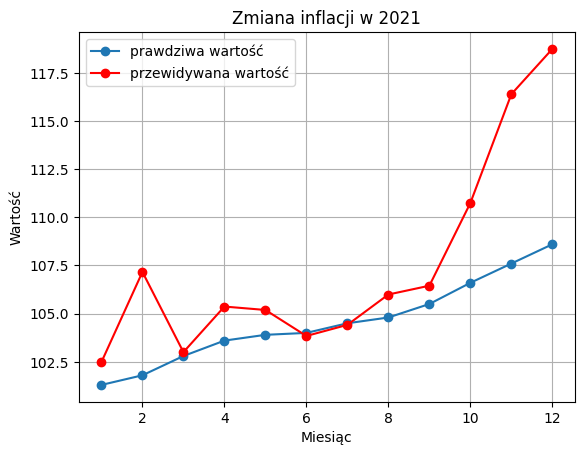

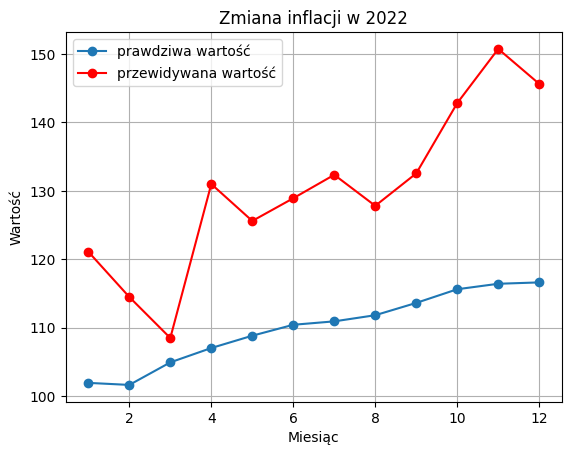

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	baz	
TRAIN: R2=0.5731496701569774, MSE=1.2994007310121163, RMSE=1.1399125979706146, MAPE=0.008005291173610016
TEST: R2=0.30838491208048346, MSE=2.901754995504217, RMSE=1.7034538430800574, MAPE=0.011337843309104543


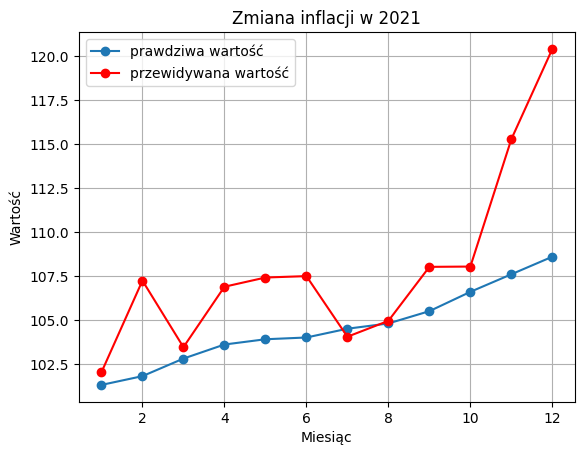

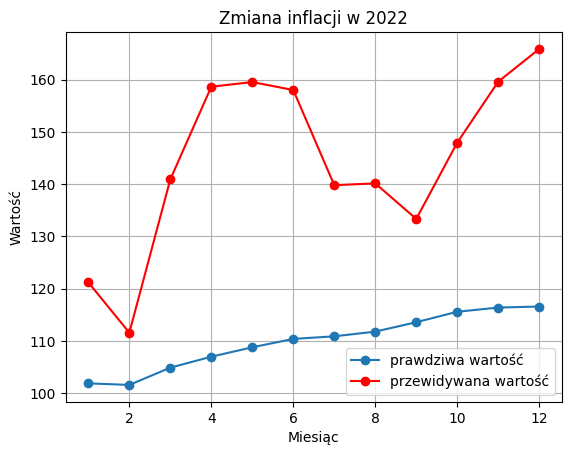

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	baz	
TRAIN: R2=0.5397150558398622, MSE=1.4597484016578965, RMSE=1.2082004807389777, MAPE=0.009035020053813224
TEST: R2=-15.443541117455556, MSE=42.02012722593682, RMSE=6.482293361607203, MAPE=0.03647238834478569


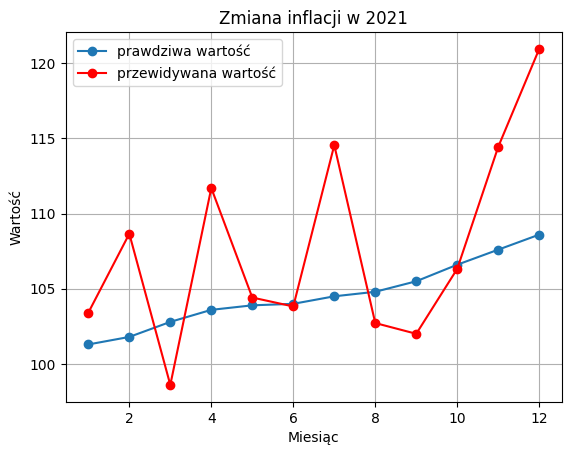

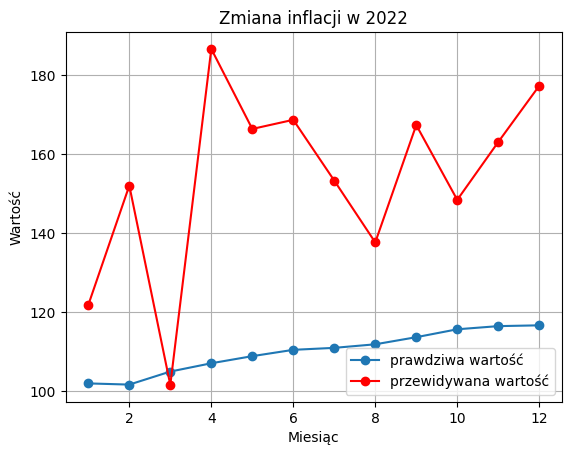

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	baz	
TRAIN: R2=-4.860740886249198, MSE=14.150455233633368, RMSE=3.7617090841309575, MAPE=0.028735145160550927
TEST: R2=-21.646205570390904, MSE=50.8769862790739, RMSE=7.132810545575558, MAPE=0.05731449384951653


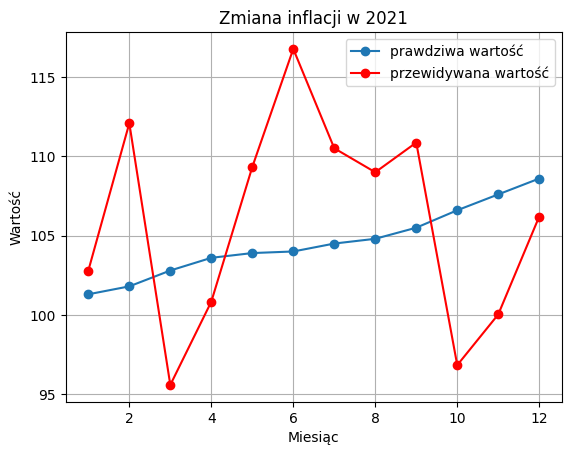

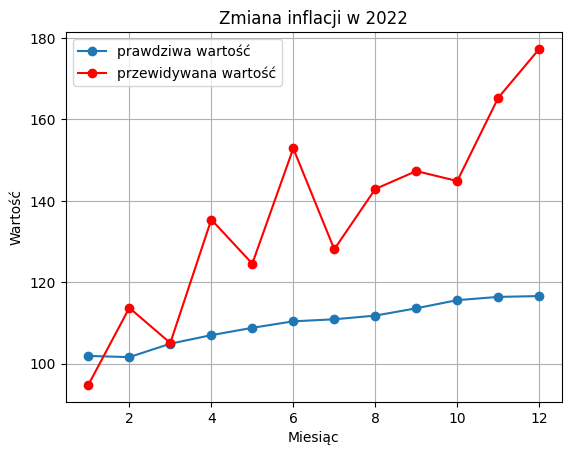

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	bezrob	mieszk	wynag	baz	
TRAIN: R2=0.7430543817600497, MSE=0.6894756938333848, RMSE=0.8303467310909249, MAPE=0.005245415787629238
TEST: R2=0.7323592694521481, MSE=1.9851555524862328, RMSE=1.4089554827907917, MAPE=0.008900284020255143


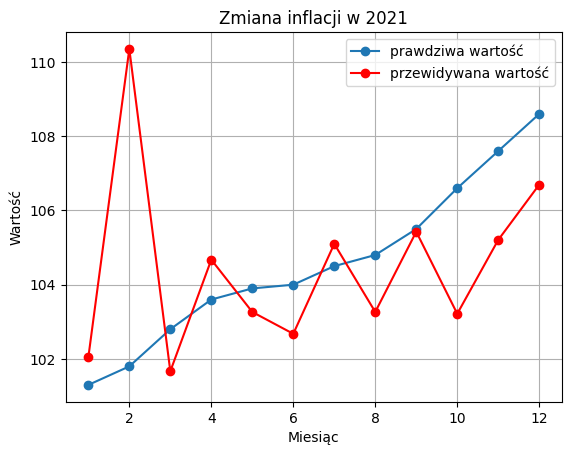

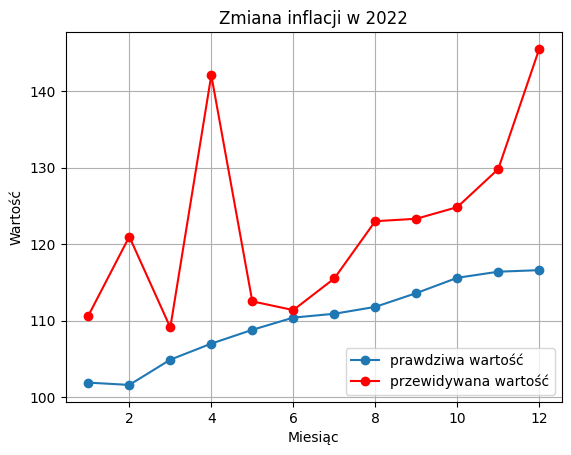

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	bezrob	mieszk	wynag	baz	
TRAIN: R2=0.4402230102421414, MSE=1.7607645906107425, RMSE=1.326938050781099, MAPE=0.009924749386620095
TEST: R2=-4.199164575572707, MSE=17.052136531581272, RMSE=4.129423268639493, MAPE=0.024565433702377987


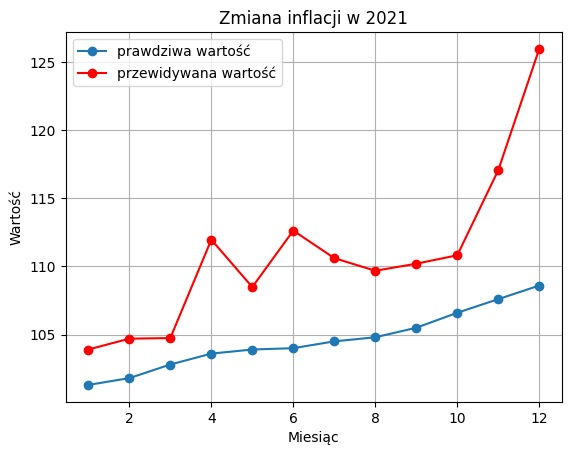

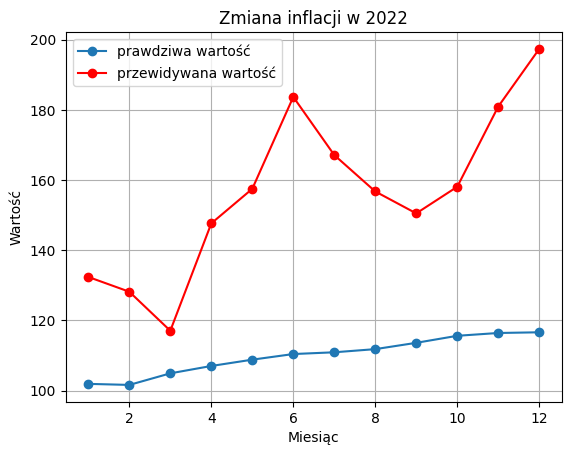

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	bezrob	mieszk	wynag	baz	
TRAIN: R2=-0.06533074327271371, MSE=3.06899693031885, RMSE=1.7518552823560654, MAPE=0.013463630035880485
TEST: R2=-3.0611115582609596, MSE=21.824100412523006, RMSE=4.671627169683279, MAPE=0.03030227341984392


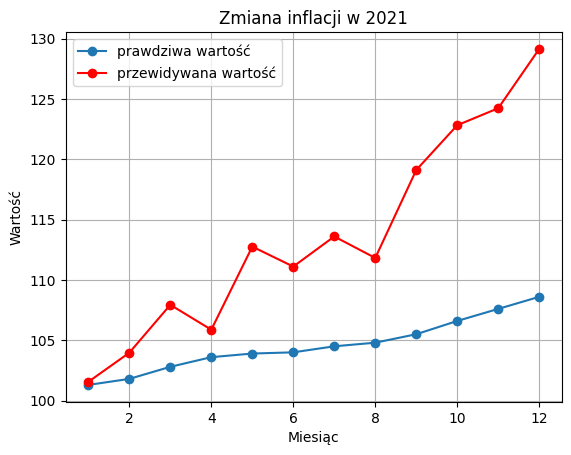

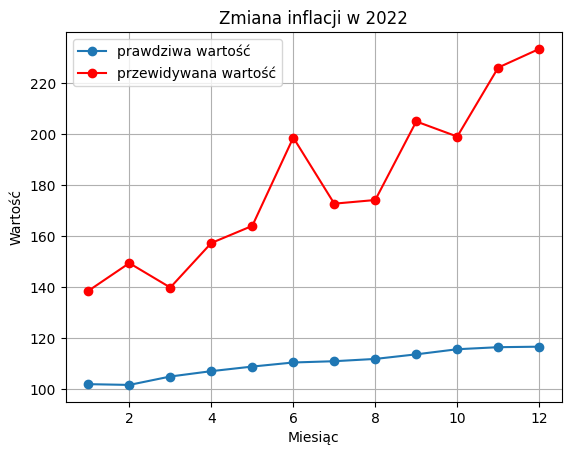

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


Wskaźniki:
inflR	inflM	bezrob	mieszk	wynag	baz	
TRAIN: R2=-3.157573141254586, MSE=10.283922584628911, RMSE=3.2068555603002937, MAPE=0.022168851490918542
TEST: R2=-10.166695372671889, MSE=15.982095275155649, RMSE=3.9977612829126814, MAPE=0.03265100363320835


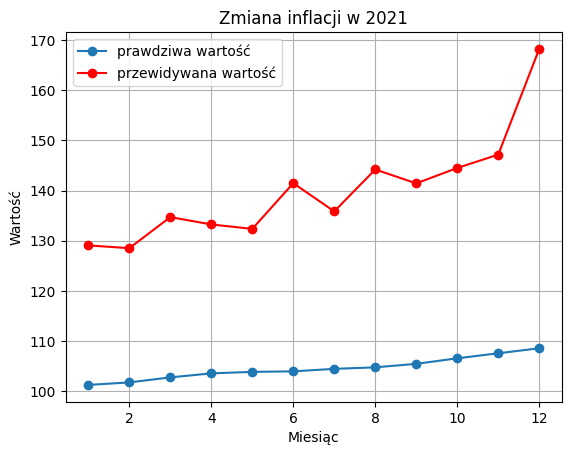

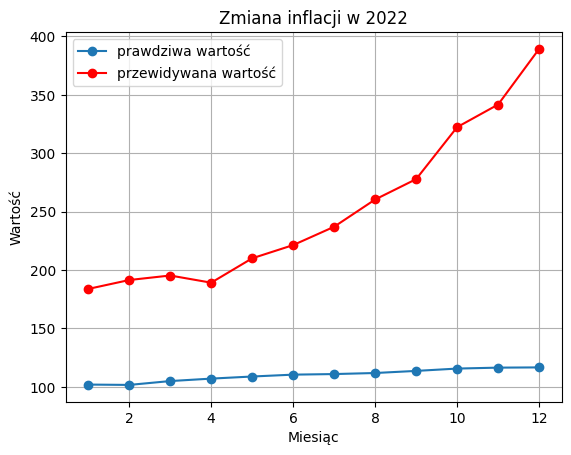

In [50]:
model_args_indices_tab = [[0], [0], [0], [0], [1], [1], [1], [1], [5], [5], [5],
                          [5], [0, 1, 5],[0, 1, 5],[0, 1, 5],[0, 1, 5], [0,1,2,3,4,5],
                          [0,1,2,3,4,5], [0,1,2,3,4,5], [0,1,2,3,4,5]]
models = [MLPRegressor(solver='adam',hidden_layer_sizes=(15, 15),
                       max_iter = 3_000, tol = 1e-3, activation = 'relu')] * len(model_args_indices_tab)
inflation_steps = [1, 3, 6, 12] * 5
steps = [1, 3, 6, 12] * 5
start_years = [1995] * len(model_args_indices_tab)
end_years = [2020] * len(model_args_indices_tab)
inference_years = [2021] * len(model_args_indices_tab)

R2s = []
MSEs = []
RMSEs = []
MAPEs = []

loop_parameters = zip(inflation_steps, steps, model_args_indices_tab, start_years,
                      end_years, inference_years, models, strict=True)
for inflation_step, step, indices, start_year, end_year, inference_year, model in loop_parameters:
    inflation_dict = load_inflation(step = inflation_step)
    target_inflation_dict = {key: inflation_dict[key][1] for key in inflation_dict}
    inflation_to_last_year_dict = {key: inflation_dict[key][0][:inflation_step] for key in inflation_dict}
    inflation_to_last_month_dict = {key: inflation_dict[key][0][inflation_step:] for key in inflation_dict}
    unemployed_dict = load_unemployed(step = step)
    building_price_dict = load_building_price(step = step)
    average_salary_dict = load_avarage_salary(step = step)
    notional_amount = load_notional_amount(step=step)
    args_dict_tab = [inflation_to_last_year_dict, inflation_to_last_month_dict,
                    unemployed_dict, building_price_dict, average_salary_dict,
                     notional_amount]
    model_args_tab = []
    print("Wskaźniki:")
    for index in indices:
        model_args_tab.append(args_dict_tab[index])
        print(names[index], end="\t")
    print()
    final_data = prepare_training_data(model_args_tab, target_inflation_dict, start_year, end_year)
    X_train, X_test, y_train, y_test, scaler = normalize_and_split_data_chronologically(final_data, test_size=0.1)
    model.fit(X_train, y_train)
    R2, MSE, RMSE, MAPE = calculate_metrics(X_train,y_train,model)
    print(f"TRAIN: {R2=}, {MSE=}, {RMSE=}, {MAPE=}")
    R2, MSE, RMSE, MAPE = calculate_metrics(X_test,y_test,model)
    print(f"TEST: {R2=}, {MSE=}, {RMSE=}, {MAPE=}")
    R2s.append(R2)
    MSEs.append(MSE)
    RMSEs.append(RMSE)
    MAPEs.append(MAPE)
    inference_data = prepare_training_data(model_args_tab, target_inflation_dict, inference_year, inference_year)
    X, y = prepare_inference_data(inference_data, scaler)
    y_pred = model.predict(X)
    plot_predicted_inflation(y,y_pred,inference_year)
    inference_data = prepare_training_data(model_args_tab, target_inflation_dict, inference_year+1, inference_year+1)
    X, y = prepare_inference_data(inference_data, scaler)
    y_pred = model.predict(X)
    plot_predicted_inflation(y,y_pred,inference_year+1)

In [51]:
columns = ['Parametry eksperymentu', 'R2', 'MSE', "RMSE", "MAPE"]
parameters_str = [
    'Wskaźniki: inflR; zasięg: 1',
    'Wskaźniki: inflR; zasięg: 3',
    'Wskaźniki: inflR; zasięg: 6',
    'Wskaźniki: inflR; zasięg: 12',
    'Wskaźniki: inflM; zasięg: 1',
    'Wskaźniki: inflM; zasięg: 3',
    'Wskaźniki: inflM; zasięg: 6',
    'Wskaźniki: inflM; zasięg: 12',
    'Wskaźniki: baz; zasięg: 1',
    'Wskaźniki: baz; zasięg: 3',
    'Wskaźniki: baz; zasięg: 6',
    'Wskaźniki: baz; zasięg: 12',
    'Wskaźniki: inflR, inflM, baz; zasięg: 1',
    'Wskaźniki: inflR, inflM, baz; zasięg: 3',
    'Wskaźniki: inflR, inflM, baz; zasięg: 6',
    'Wskaźniki: inflR, inflM, baz; zasięg: 12',
    'Wskaźniki: inflR, inflM, bezrob, mieszk, baz; zasięg: 1',
    'Wskaźniki: inflR, inflM, bezrob, mieszk, baz; zasięg: 3',
    'Wskaźniki: inflR, inflM, bezrob, mieszk, baz; zasięg: 6',
    'Wskaźniki: inflR, inflM, bezrob, mieszk, baz; zasięg: 12',
    ]
values = zip(parameters_str, R2s, MSEs, RMSEs, MAPEs, strict=True)
print_table(columns, values)

Parametry eksperymentu	R2	MSE	RMSE	MAPE
Wskaźniki: inflR; zasięg: 1	0.0660	2.3662	1.5382	0.0072	
Wskaźniki: inflR; zasięg: 3	0.3317	6.1304	2.4760	0.0112	
Wskaźniki: inflR; zasięg: 6	0.1874	5.8508	2.4188	0.0098	
Wskaźniki: inflR; zasięg: 12	0.7796	5.4047	2.3248	0.0127	
Wskaźniki: inflM; zasięg: 1	0.4621	9.6225	3.1020	0.0182	
Wskaźniki: inflM; zasięg: 3	0.2084	7.4723	2.7335	0.0162	
Wskaźniki: inflM; zasięg: 6	0.3471	10.5364	3.2460	0.0179	
Wskaźniki: inflM; zasięg: 12	-2.6502	18.4106	4.2908	0.0161	
Wskaźniki: baz; zasięg: 1	0.4091	1.5351	1.2390	0.0104	
Wskaźniki: baz; zasięg: 3	0.4077	1.3431	1.1589	0.0092	
Wskaźniki: baz; zasięg: 6	0.4457	1.0443	1.0219	0.0084	
Wskaźniki: baz; zasięg: 12	0.5136	0.7918	0.8898	0.0073	
Wskaźniki: inflR, inflM, baz; zasięg: 1	0.9171	0.2772	0.5265	0.0038	
Wskaźniki: inflR, inflM, baz; zasięg: 3	0.3084	2.9018	1.7035	0.0113	
Wskaźniki: inflR, inflM, baz; zasięg: 6	-15.4435	42.0201	6.4823	0.0365	
Wskaźniki: inflR, inflM, baz; zasięg: 12	-21.6462	50.